In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from intercluster.clustering import *
from intercluster.rules import *
from intercluster.experiments import *
from intercluster import *

%load_ext autoreload
%autoreload 2

In [12]:
np.random.randint(1)

0

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [3]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

cmap2 = ["white", cmap(5)]
cmap2 = ListedColormap(cmap2)

### Data

In [172]:
shapefile_path = '../data/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

/project/mcnet/kevin/explainable_clustering/venv/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [173]:
climate_data = pd.read_csv('../data/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

In [174]:
# change months to seasons\n",
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)

In [175]:
unscaled_data = climate_change.to_numpy()
feature_labels = climate_change.columns

scaler = MinMaxScaler()
data = scaler.fit_transform(unscaled_data)

In [176]:
scaler

MinMaxScaler()

In [177]:
scaler.data_min_

array([-4.66791015e-01, -5.88439729e-01, -4.94768408e-01, -7.30394475e-01,
       -4.36483057e-01, -6.26006904e-01, -6.29261364e-01, -5.92321520e-01,
       -4.19083539e-01, -4.11379987e-01, -4.80553134e-01, -2.35635670e-01,
        4.51644420e-03, -1.56718526e-01,  6.51397986e-03, -8.92224658e-02,
       -9.96231377e-03,  7.19266973e-04, -1.97970176e-02, -1.12975194e-02,
        8.31994567e-03, -2.44044725e-02, -4.75596445e-03, -1.33170948e-03])

In [178]:
scaler.data_max_

array([0.38210012, 0.64926171, 0.45984096, 0.61388713, 0.63439307,
       0.50412505, 0.57192093, 0.6669301 , 0.63898782, 0.70410511,
       0.78566839, 1.32125348, 3.56925274, 0.27797542, 0.14745445,
       0.07432751, 0.06000992, 0.06655296, 0.05733178, 0.06360673,
       0.07352007, 0.07342126, 0.11250036, 0.54722898])

### KMeans

In [197]:
np.random.seed(seed)

In [198]:
k = 7
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_assignment = labels_to_assignment(kmeans.labels_)
cost = kmeans_cost(data, kmeans_assignment, kmeans.cluster_centers_, normalize = True)

In [199]:
cost

0.013150172344118163

([], [])

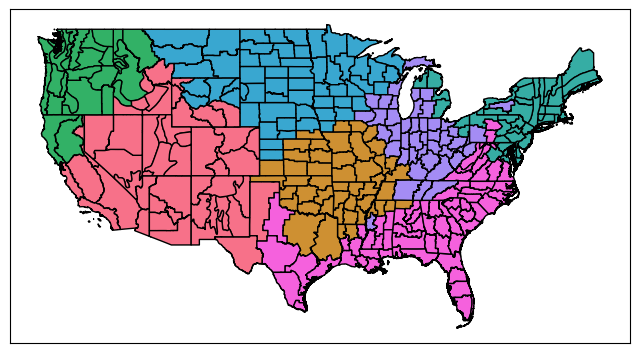

In [10]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = kmeans.labels_[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/decision_sets/kmeans.png', bbox_inches = 'tight', dpi = 300)

### IMM / ExKMC

In [210]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = 7,
    imm = True, 
    feature_labels = feature_labels
)
exkmc_tree.fit(data)
exkmc_data_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_data_labels = exkmc_data_labels.astype(int)
exkmc_rules, exkmc_rule_labels = get_decision_paths_with_labels(
    exkmc_tree.root,
    exkmc_data_labels,
    np.unique(exkmc_data_labels)
)

([], [])

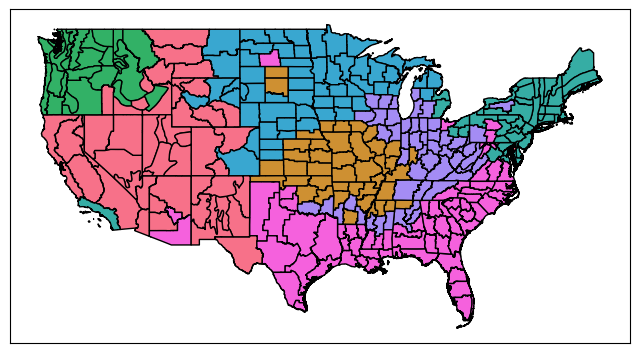

In [219]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = exkmc_data_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/decision_sets/kmeans.png', bbox_inches = 'tight', dpi = 300)

In [235]:
fname = '../figures/decision_sets/exkmc_rule_list.png'
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    exkmc_rules,
    feature_labels,
    flatten_labels(exkmc_rule_labels),
    cluster_colors,
    data_scaler = scaler,
    filename = fname
)

In [72]:
tree = ExTree(k, max_leaves = 14, base_tree =  'IMM')
exkmc_labels = tree.fit_predict(data, kmeans=kmeans)
exkmc_assignment = labels_to_assignment(exkmc_labels)
exkmc_centers = tree.all_centers
cost = kmeans_cost(data, exkmc_assignment, exkmc_centers, normalize = True)

In [73]:
cost

0.01371660953526238

### Decision Forest

Build a random forest as a collection of centroid trees on randomly chosen subsets of features. 

Let $p$ denote the maximum depth we allow tree to take.

* For every tree choose depth as $\mathrm{uniform}([1,2,...,p])$

Let $F_1,...,F_{\ell}$ denote feature subsets which are allowed to be used together in a tree. Let $w$ denote the maximum number of features used for each tree.

* For every tree randomly choose a subset of features $F_i$ as $\mathrm{uniform}([F_1,F_2,...,F_{\ell}])$

* Choose the number of features to use from $\mathrm{uniform}([1,2,...,\min\{w, |F_i|\}])$

* Uniformly choose these features from $F_i$

Once we have a depth and a subset of features, $F_i$, we may then train a centroid tree on the subset of data corresponding to the chosen features $X[:,F_i]$. 

This is then done over a series of $s$ samples.

In [242]:
np.random.seed(13982)

In [243]:
feature_pairings = [list(range(12))] + [list(range(12,24))]

forest_tree_params = {
    'max_depth' : 2
}

forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 1000,
    max_features = 6,
    max_labels = 1,
    feature_pairings = feature_pairings, 
    train_size = 0.5,
    feature_labels = feature_labels
)

forest.fit(data, kmeans.labels_)

data_to_rules_labels = forest.predict(data, leaf_labels = True)
forest_points_to_rules = labels_to_assignment(data_to_rules_labels,
                                            k = len(forest.decision_set))
forest_data_labels = [[l] for l in kmeans.labels_]

forest_rule_labels = forest.decision_set_labels
forest_rule_assignment = labels_to_assignment(forest_rule_labels, k = k)

In [244]:
q = 7
search_range = np.linspace(0,10,100)
coverage_threshold = 0.9 * len(data)

def clustering_objective(S):
    A = forest_points_to_rules[:, S]
    B = forest_rule_assignment[S, :]
    pruned_assignment = np.dot(A,B)
    return kmeans_cost(data, pruned_assignment, kmeans.cluster_centers_, normalize = True)

In [245]:
selected_rules = prune_with_grid_search(
    q,
    forest_data_labels,
    forest_rule_labels,
    forest.covers,
    clustering_objective,
    search_range,
    coverage_threshold
)
selected_rule_labels = [forest_rule_labels[r] for r in selected_rules]
pruned_forest = [forest.decision_set[r] for r in selected_rules]

print('Clustering Objective value: ' + str(clustering_objective(selected_rules)))

Clustering Objective value: 0.013774684390912024


In [246]:
selected_rules

array([ 269,    1, 1060,  205,  271, 1051,  219])

In [247]:
rule_covers = forest.get_covers(data)
covered_points = set()
for r in selected_rules:
    covered_points = covered_points.union(rule_covers[r])

print(len(covered_points))

312


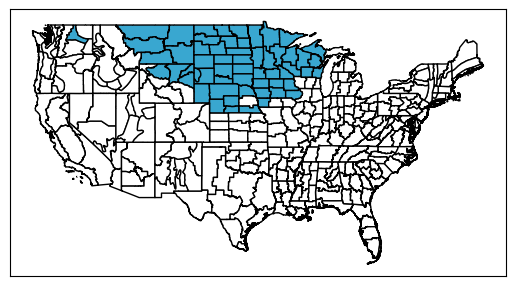

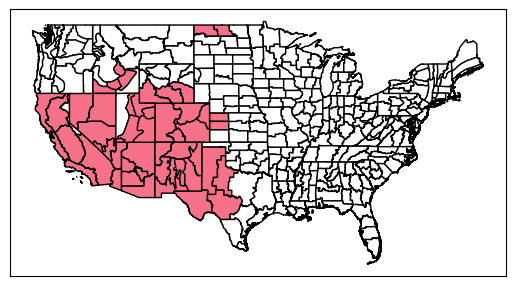

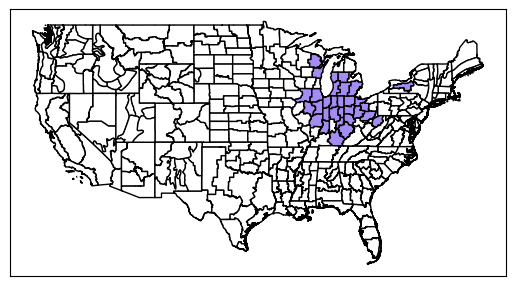

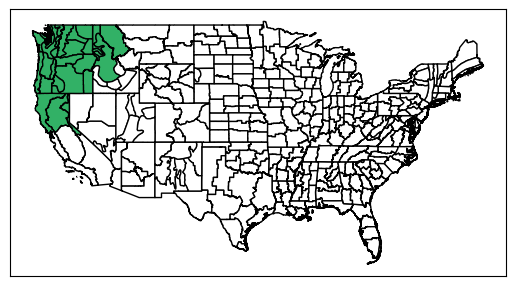

In [248]:
#fig,ax = plt.subplots(q, 1, figsize = (8,8*q), dpi = 100)

for r in range(q):
    r_labels = np.zeros(len(data)) - 1
    r_labels[rule_covers[selected_rules[r]]] = r
    
    label_array = np.empty(len(gdf))
    label_array[:] = np.nan
    for i,ide in enumerate(climate_change.index):
        idx = gdf.loc[gdf.CLIMDIV == ide].index
        if len(idx) == 1:
            label_array[idx[0]] = r_labels[i]

    fig,ax = plt.subplots(dpi = 100)
    c = selected_rule_labels[r]
    new_cmap = ["white", cmap_subset(c)]
    new_cmap = ListedColormap(new_cmap)
    gdf['cluster'] = label_array
    gdf.plot(column='cluster', cmap=new_cmap, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
    plt.xticks([])
    plt.yticks([]) 
    plt.savefig('../figures/decision_sets/rule_' + str(r) + '.png', bbox_inches = 'tight', dpi = 300)

In [201]:
pruned_forest

[[(<intercluster.rules._node.Node at 0x14e669bae8b0>, 'right'),
  (<intercluster.rules._node.Node at 0x14e669bae220>, 'right'),
  (<intercluster.rules._node.Node at 0x14e669baed30>, None)],
 [(<intercluster.rules._node.Node at 0x14e669b7ffd0>, 'left'),
  (<intercluster.rules._node.Node at 0x14e669b7ff40>, 'right'),
  (<intercluster.rules._node.Node at 0x14e6691c3df0>, None)],
 [(<intercluster.rules._node.Node at 0x14e6687f0760>, 'left'),
  (<intercluster.rules._node.Node at 0x14e6687f08b0>, 'right'),
  (<intercluster.rules._node.Node at 0x14e6687f0c40>, None)],
 [(<intercluster.rules._node.Node at 0x14e669b5d9a0>, 'left'),
  (<intercluster.rules._node.Node at 0x14e669b5d880>, 'left'),
  (<intercluster.rules._node.Node at 0x14e669b5df70>, None)],
 [(<intercluster.rules._node.Node at 0x14e669bae940>, 'left'),
  (<intercluster.rules._node.Node at 0x14e669bae190>, 'left'),
  (<intercluster.rules._node.Node at 0x14e669baef40>, None)],
 [(<intercluster.rules._node.Node at 0x14e6687f0eb0>, 'l

In [234]:
fname = '../figures/decision_sets/rule_list.png'
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(
    pruned_forest,
    feature_labels,
    flatten_labels(selected_rule_labels),
    cluster_colors,
    data_scaler = scaler,
    filename = fname
)

### Decision Forest with Clustering

Once we have a forest we can cluster all of its leaves to produce a complete picture of what the forest looks like in aggregation.

In [85]:
rules = forest
rule_kmeans = KMeansRuleClustering(
    rules,
    k_clusters = k,
    init = 'manual',
    center_init = kmeans.cluster_centers_,
    random_seed = seed
)
rule_kmeans.fit(data, fit_rules = False)

In [99]:
model = rule_kmeans
rule_labels = assignment_to_labels(model.rule_assignment)
data_assignment = model.predict(data, assignment_method = 'min')
data_labels = assignment_to_labels(data_assignment)
#data_labels = [np.nan if _ == [] else _ for _ in data_labels]

In [100]:
kmeans_cost(data, data_assignment, rule_kmeans.centers, normalize = True)

0.013977842406524759

In [17]:
# INCLUDE A voted or minimal assignment here just for visualization??

([], [])

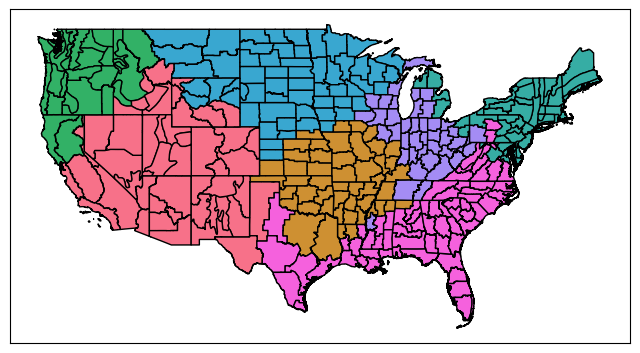

In [18]:
flattened_data_labels = flatten_labels(data_labels)
if len(flattened_data_labels) != len(data_labels):
    raise ValueError('Assumes data points have a single cluster label.')

label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = flattened_data_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8), dpi = 100)
#gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
gdf.plot(column='cluster', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
plt.xticks([])
plt.yticks([]) 
#plt.savefig('figures/climate7/centroid_oblique_clustering.png', bbox_inches = 'tight', dpi = 300)
#plt.savefig('../figures/decision_sets/voted_cluster.png', bbox_inches = 'tight', dpi = 300)

### Pruning with coverage and cost

In [19]:
q = 14
search_range = np.linspace(0,10,100)
coverage_threshold = 0.9 * len(data)

def clustering_objective(S):
    A = rule_kmeans.points_to_rules[:, S]
    B = rule_kmeans.rule_assignment[S, :]
    pruned_assignment = np.dot(A,B)
    return kmeans_cost(data, pruned_assignment, rule_kmeans.centers, normalize = True)

In [20]:
selected_rules = prune_with_grid_search(
    q,
    data_labels,
    rule_labels,
    forest.covers,
    clustering_objective,
    search_range,
    coverage_threshold
)
selected_rule_labels = [rule_labels[r] for r in selected_rules]
pruned_forest = [forest.decision_set[r] for r in selected_rules]

print('Clustering Objective value: ' + str(clustering_objective(selected_rules)))

Clustering Objective value: 0.013348950192474581


In [21]:
rule_covers = forest.get_covers(data)
covered_points = set()
for r in selected_rules:
    covered_points = covered_points.union(rule_covers[r])

print(len(covered_points))

311


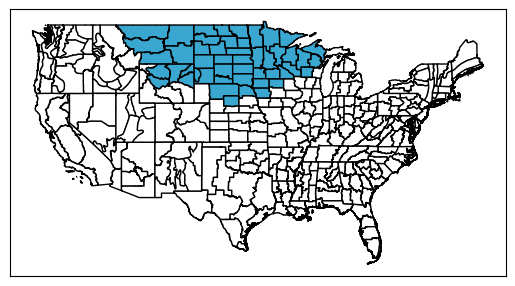

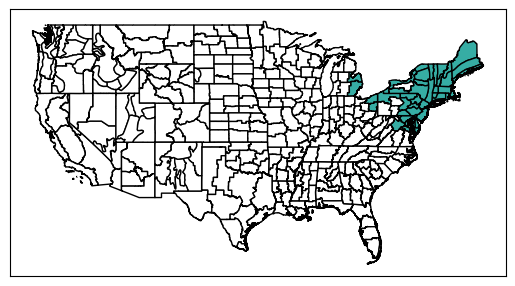

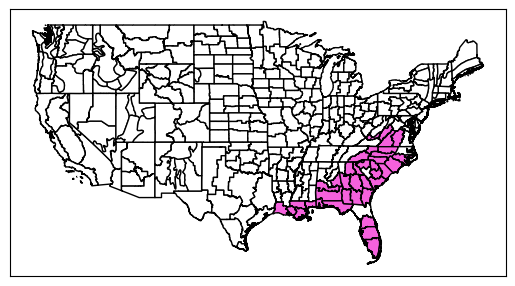

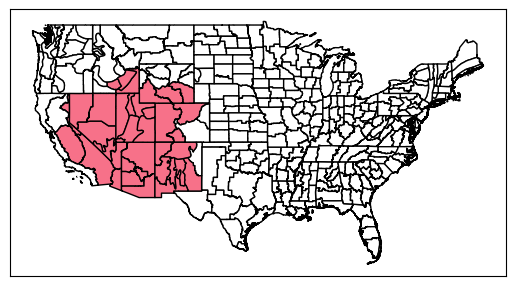

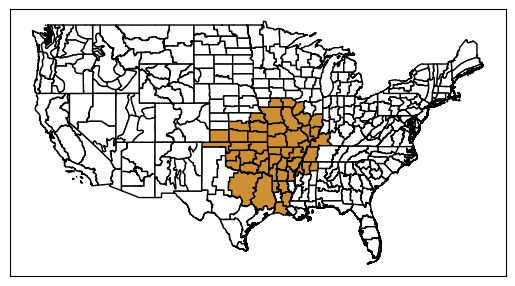

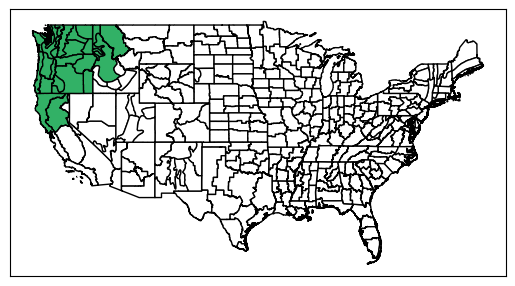

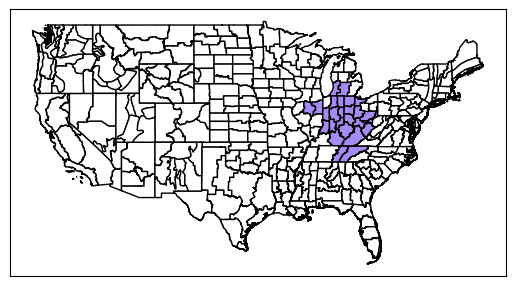

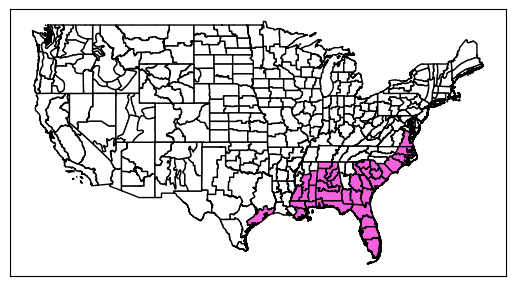

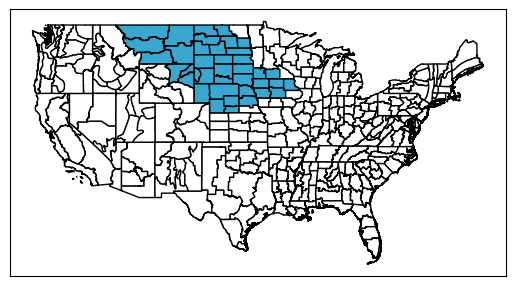

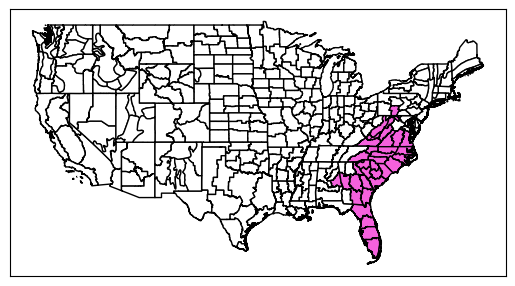

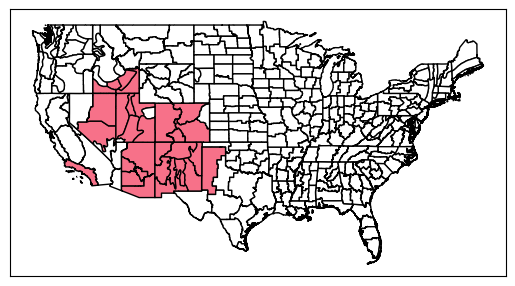

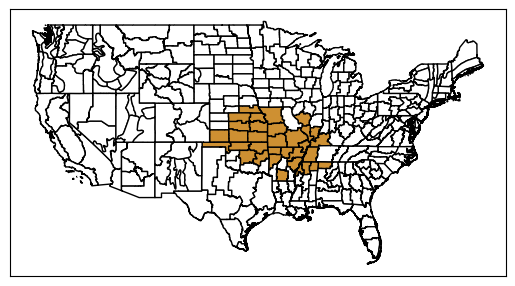

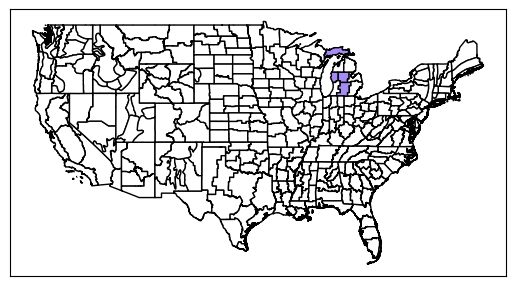

In [22]:
#fig,ax = plt.subplots(q, 1, figsize = (8,8*q), dpi = 100)

for r in range(q):
    r_labels = np.zeros(len(data)) - 1
    r_labels[rule_covers[selected_rules[r]]] = r
    
    label_array = np.empty(len(gdf))
    label_array[:] = np.nan
    for i,ide in enumerate(climate_change.index):
        idx = gdf.loc[gdf.CLIMDIV == ide].index
        if len(idx) == 1:
            label_array[idx[0]] = r_labels[i]

    fig,ax = plt.subplots(dpi = 100)
    c = selected_rule_labels[r]
    new_cmap = ["white", cmap_subset(c)]
    new_cmap = ListedColormap(new_cmap)
    gdf['cluster'] = label_array
    gdf.plot(column='cluster', cmap=new_cmap, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
    plt.xticks([])
    plt.yticks([]) 
    #plt.savefig('../figures/decision_sets/rule_' + str(r) + '.png', bbox_inches = 'tight', dpi = 300)

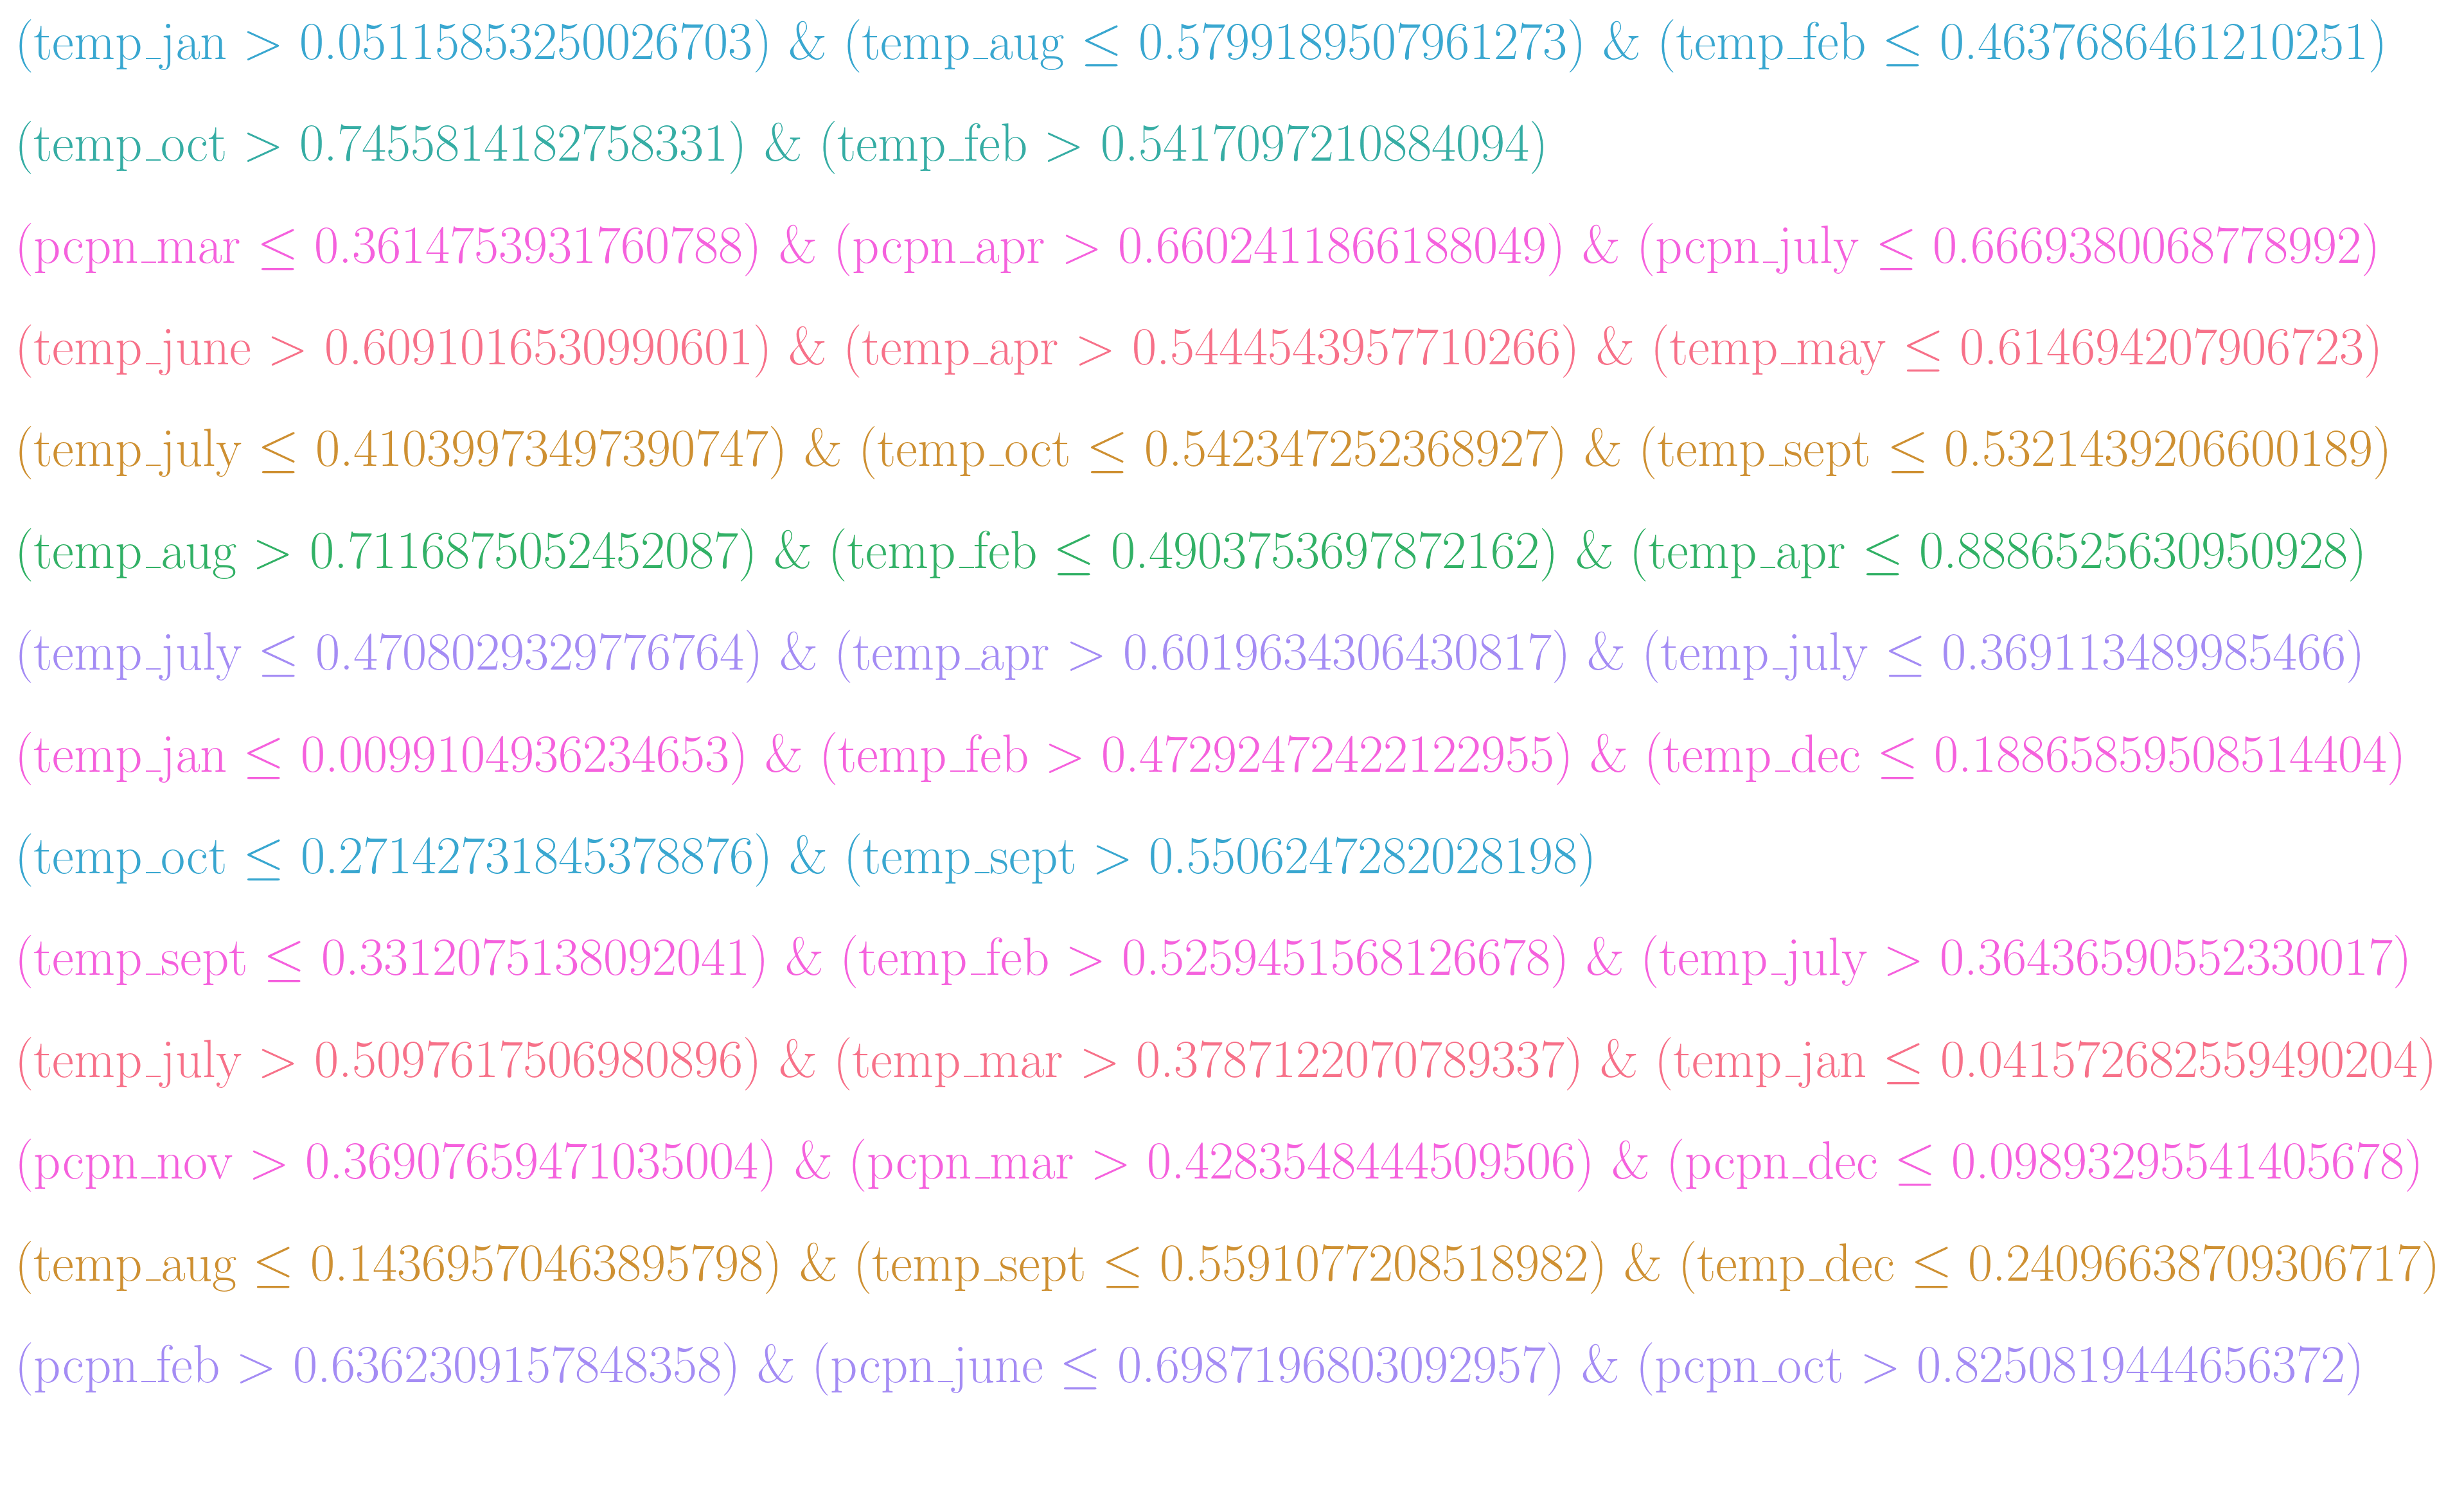

In [28]:
#fname = '../figures/decision_sets/rule_list.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(pruned_forest, feature_labels, flatten_labels(selected_rule_labels), cluster_colors, filename = fname)

### Experiments

In [118]:
# REMINDER: The seed should only be given to the experiment object which 
# initializes the seed at the beginning of the experiment. It should NOT 
# within the parameters of any sub-function or class, since these will 
# reset the seed each time they are given one. 
seed

342

In [96]:
# Parameters:
seed = seed
n_clusters = k
min_rules = k
max_rules = 2*k
min_depth = 3
max_depth = 6

# Base module
base = KMeansBase(n_clusters)
A,C = base.assign(data)
y = base.clustering.labels_

cluster_model = KMeansRuleClustering
cluster_params = {
    'k_clusters' : n_clusters,
    'init' : 'manual',
    'center_init' : C,
    'max_iterations' : 500,
}

# Modules:
mod1 = ExkmcMod(
    n_clusters = n_clusters,
    kmeans_model = base.clustering,
    base_tree = 'IMM',
    min_rules = min_rules
)

forest_tree_params = {
    'max_leaf_nodes' : max_rules,
    'max_depth' : 2
}


# Forest:
forest_params = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params,
    'num_trees' : 100,
    'max_features' : 6,
    'max_labels' : 1,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

prune_params = {
    'search_range' : np.linspace(0,1,100),
    'coverage_threshold' : 0.9 * len(data)
}

mod2 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params,
    clustering = base,
    prune_params = prune_params,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest'
)

mod3 = ForestClusterMod(
    forest_model = DecisionForest,
    forest_params = forest_params,
    clustering = base,
    cluster_model = cluster_model,
    cluster_params = cluster_params,
    assignment_method = 'vote',
    prune_params = prune_params,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Cluster-Vote'
)

mod4 = ForestClusterMod(
    forest_model = DecisionForest,
    forest_params = forest_params,
    clustering = base,
    cluster_model = cluster_model,
    cluster_params = cluster_params,
    assignment_method = 'min',
    prune_params = prune_params,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Cluster-Min'
)

baseline_list = [base]
module_list = [mod1, mod2, mod3, mod4]

In [97]:
cost_fns = {
    'standard' : kmeans_cost,
    'normalized' : kmeans_cost,
    'normalized_v2' : kmeans_cost
}

cost_fn_params = {
    'standard' : {},
    'normalized' : {'normalize' : True},
    'normalized_v2' : {'normalize' : True, 'square' : 'True'}
}

Ex1 = RulesExperiment(
    data = data,
    baseline_list = baseline_list,
    module_list = module_list,
    cost_fns = cost_fns,
    cost_fn_params = cost_fn_params,
    labels = y,
    random_seed = seed,
    verbose = True
)

Ex1_results = Ex1.run(min_rules = min_rules, max_rules = max_rules)
#Ex1.save_results('../data/experiments/decision_sets/', '_standard')

Running for 7 rules.
Running for 8 rules.
Running for 9 rules.
Running for 10 rules.
Running for 11 rules.
Running for 12 rules.
Running for 13 rules.
Running for 14 rules.


In [98]:
Ex1_results

standard                                                                 \
       KMeans       ExKMC      Forest Forest-Cluster-Vote Forest-Cluster-Min   
0  108.567823  124.088263  172.700482          158.345599         146.308025   
1  108.567823  122.057277  180.147732          162.594463         145.810502   
2  108.567823  120.235404  175.788214          147.169663         144.535444   
3  108.567823  118.463224  176.994014          148.453813         145.450463   
4  108.567823  116.932925  178.712057          148.657135         134.818848   
5  108.567823  115.544814  191.448530          146.441006         136.600344   
6  108.567823  114.235039  186.735504          147.308127         132.785215   
7  108.567823  113.244328  178.063830          147.308127         133.093499   

  normalized                                                             \
      KMeans     ExKMC    Forest Forest-Cluster-Vote Forest-Cluster-Min   
0    0.01315  0.015030  0.016900            0.016451           0.015324   
1    0.01315  0.014784  0.015711            0.016621           0.015286   
2    0.01315  0.014563  0.017164            0.016684           0.015420   
3    0.01315  0.014349  0.017041            0.016748           0.015360   
4    0.01315  0.014163  0.017004            0.016800           0.015235   
5    0.01315  0.013995  0.016956            0.016700           0.015331   
6    0.01315  0.013837  0.017021            0.016763           0.015288   
7    0.01315  0.013717  0.016596            0.016763           0.015280   

  normalized_v2                                                             
         KMeans     ExKMC    Forest Forest-Cluster-Vote Forest-Cluster-Min  
0      0.000917  0.001049  0.001304            0.001257           0.001183  
1      0.000917  0.001031  0.001143            0.001250           0.001165  
2      0.000917  0.001016  0.001325            0.001283           0.001182  
3      0.000917  0.001001  0.001315            0.001280           0.001167  
4      0.000917  0.000988  0.001308            0.001296           0.001179  
5      0.000917  0.000976  0.001268            0.001293           0.001187  
6      0.000917  0.000965  0.001297            0.001294           0.001184  
7      0.000917  0.000957  0.001277            0.001294           0.001179

In [ ]:
cost_fns = {
    'standard' : kmeans_cost,
    'normalized' : kmeans_cost,
    'normalized_v2' : kmeans_cost
}

cost_fn_params = {
    'standard' : {},
    'normalized' : {'normalize' : True},
    'normalized_v2' : {'normalize' : True, 'square' : 'True'}
}

Ex2 = DepthExperiment(
    data = data,
    baseline_list = baseline_list,
    module_list = module_list,
    cost_fns = cost_fns,
    cost_fn_params = cost_fn_params,
    random_seed = seed,
    verbose = True
)

Ex2_results = Ex2.run(min_depth = min_depth, max_depth = max_depth)

### Plotting Results

In [229]:

directory = '../data/experiments/decision_sets/'

rules_cost_filename = os.path.join(directory, 'rules_cost_climate_no_cluster3.csv')
depth_cost_filename = os.path.join(directory, 'depth_cost_climate.csv')

rules_cost = pd.read_csv(rules_cost_filename, index_col = 0, header = [0,1])
depth_cost = pd.read_csv(depth_cost_filename, index_col = 0, header = [0,1])

rules_cost_standard = rules_cost['standard']
rules_cost_normalized = rules_cost['normalized']
#rules_cost_normalized = rules_cost_normalized.drop(columns = ['Forest-Vote', 'Forest-Min', 'Forest-No-Cluster'])
rules_cost_normalized_v2 = rules_cost['normalized_v2']

depth_cost_standard = depth_cost['standard']
depth_cost_normalized = depth_cost['normalized']
depth_cost_normalized_v2 = depth_cost['normalized_v2']

In [14]:
'''
rules_cost_standard = Ex1_results['standard']
rules_cost_normalized = Ex1_results['normalized']
rules_cost_normalized_v2 = Ex1_results['normalized_v2']
'''

"\nrules_cost_standard = Ex1_results['standard']\nrules_cost_normalized = Ex1_results['normalized']\nrules_cost_normalized_v2 = Ex1_results['normalized_v2']\n"

In [237]:
#0,1,3
def plotter(cost_df, xlabel, ylabel, domain, cmap, filename = None):
    fig,ax = plt.subplots(figsize = (6,4))
    baseline_list = ['KMeans']
    baseline_linestyles = ['-']
    baselines = [_ for _ in cost_df.columns if _ in baseline_list]
    modules = [_ for _ in cost_df.columns if _ not in baselines]
    
    end = -1
    for i,b in enumerate(baselines):
        ax.hlines(
            cost_df[b].iloc[0],
            xmin = domain[0],
            xmax = domain[end],
            color = 'k',
            label = fr'$\texttt{{{b}}}$',
            linestyle = baseline_linestyles[i],
            linewidth = 3,
            alpha = 0.6
        )
    
    for i,m in enumerate(modules):
        ax.plot(
            domain,
            np.array(cost_df[m]),
            linewidth = 3,
            marker='o',
            markersize = 5,
            c = cmap(i),
            label = fr'$\texttt{{{m}}}$'
        )

    ticks = np.arange(domain[0], domain[end] + 1, 1) 
    labels = [str(i) for i in ticks] 
    plt.xticks(ticks, labels)

    plt.legend(loc = 'upper right', bbox_to_anchor=(2, 1))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if filename is not None:
        plt.savefig(filename, bbox_inches = 'tight', dpi = 300)
    plt.show()

In [238]:
plotter(
    rules_cost_standard,
    xlabel = 'Number of Rules',
    ylabel = '$f_2$',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    filename = '../figures/decision_sets/standard_cost_comparison.png'
)

In [239]:
plotter(
    rules_cost_normalized,
    xlabel = 'Number of Rules',
    ylabel = '$g_2$',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap,
    filename = '../figures/decision_sets/normalized_cost_comparison.png'
)

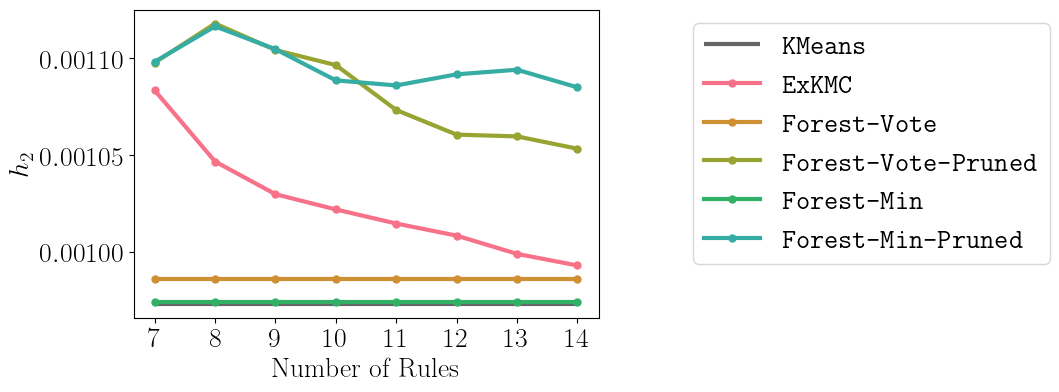

In [18]:
plotter(
    rules_cost_normalized_v2,
    xlabel = 'Number of Rules',
    ylabel = '$h_2$',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap
)

In [ ]:
### plotter(
    depth_cost_standard,
    xlabel = 'Depth',
    ylabel = '$f_2$',
    domain = list(range(3, 6 + 1)),
    cmap = cmap
)

In [19]:
plotter(
    depth_cost_normalized,
    xlabel = 'Depth',
    ylabel = '$g_2$',
    domain = list(range(3, 6 + 1)),
    cmap = cmap
)

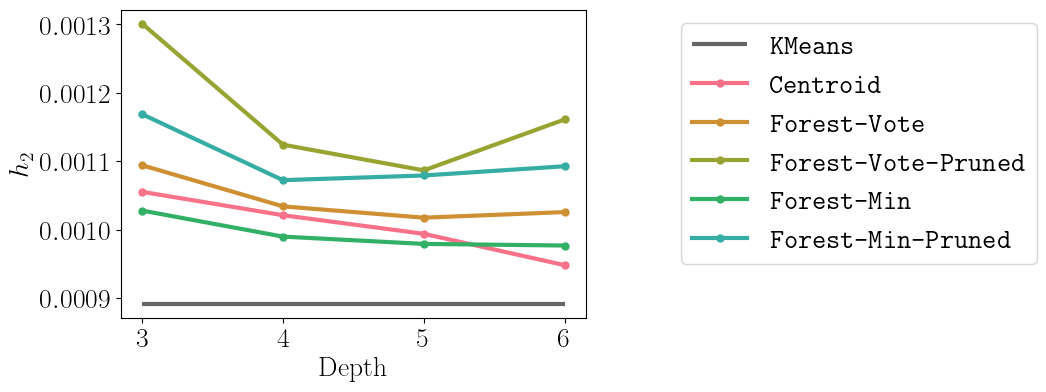

In [20]:
plotter(
    depth_cost_normalized_v2,
    xlabel = 'Depth',
    ylabel = '$h_2$',
    domain = list(range(3, 6 + 1)),
    cmap = cmap
)